### Importing required libraries

In [223]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.metrics import euclidean_distances


### Function to get neighbours within epsilon

In [224]:
def get_neighbors(vectors, epsilon) ### Function to get neighbours within epsilonors, epsilon):
    distances = euclidean_distances(vectors)
    neighbor_indices = np.argwhere(distances < epsilon)
    dbscan_dict = dict()
    for index in neighbor_indices:
        if index[0] in dbscan_dict:
            dbscan_dict[index[0]].append(index[1])
        else:
            dbscan_dict[index[0]] = [index[1]]
    return dbscan_dict

### Function to get list of points having specific number of neighbours

In [225]:
def num_neighbor(dbscan_dict):
    num_neighbo### Function to get neighbours within epsilonr_list = dict()
    for i,(key,value) in enumerate (dbscan_dict.items()):
        #print(len(value))
        if len(value) in num_neighbor_list:
            num_neighbor_list[len(value)].append(key)
        else:
            temp = []
            temp.append(key)
            num_neighbor_list[len(value)] = temp
            
    return num_neighbor_list

### Function to define point as core, non-core and outliers

In [226]:
def defining_points(MinPts,num_neighbor_list):
    cores, non_cores, outliers = list(), list(), list()
    
    [cores.extend(num_neighbor_list[i])
     for i in num_neighbor_list if i >= MinPts]
    
    [non_cores.extend(num_neighbor_list[i])
     for i in num_neighbor_list if i < MinPts and i > 1]
    
    [outliers.extend(num_neighbor_list[i])
     for i in num_neighbor_list if i == 1]
    
    return cores,non_cores,outliers

### Function to create clusters

In [227]:
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point iscore, neighbour or border
            if curr_idx in cores:
                iscore = True
                isborder = False
                isnoise = False
            
            if curr_idx in non_cores:
                iscore = False
                isborder = True
                isnoise = False 
                
            if curr_idx in outliers:
                iscore = False
                isborder = False
                isnoise = True 
                
            neigh_indexes = dbscan_dict[curr_idx]
            #print(neigh_indexes, iscore, isborder, isnoise)
                
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters

### Executing for moons dataset

In [228]:
epsilon = 0.25
minPts = 3
df = pd.read_csv('moons.csv')
df = df.rename(columns={'Xmoons_X1': 'X',
                        'Xmoons_X2': 'Y'})
df = df.reset_index(drop=False)
df.head()

,index,X,Y
0,0,-0.378142,0.940750
1,1,0.933566,0.153805
2,2,2.048309,0.498172
3,3,0.947891,0.162473
4,4,2.000739,0.183700


Text(0.5, 1.0, 'Scattered data')

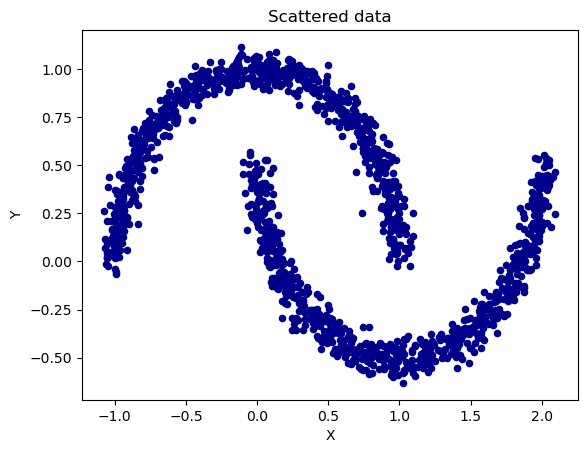

In [229]:
df.plot.scatter(x='X', y='Y', c='DarkBlue')
plt.title("Scattered data")

In [230]:
dbscan_dict = {}
vectors = df[["X", "Y"]].to_numpy()
dbscan_dict = get_neighbors(vectors, epsilon)

In [231]:
num_neighbor_list = num_neighbor(dbscan_dict)
cores,non_cores,outliers = defining_points(minPts,num_neighbor_list)

In [232]:
#data
clustered = cluster_with_stack(eps, minPts, df)

idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["index", "cluster"])

In [233]:
merged_df = pd.merge(df, cluster_df, on ='index')

In [234]:
merged_df

,index,X,Y,cluster
0,0,-0.378142,0.940750,2
1,1,0.933566,0.153805,2
2,2,2.048309,0.498172,1
3,3,0.947891,0.162473,2
4,4,2.000739,0.183700,1
...,...,...,...,...
1495,1495,-0.022346,0.425338,1
1496,1496,0.090974,0.098361,1
1497,1497,1.390850,-0.439987,1
1498,1498,-0.652389,0.769648,2


<Figure size 1000x700 with 0 Axes>

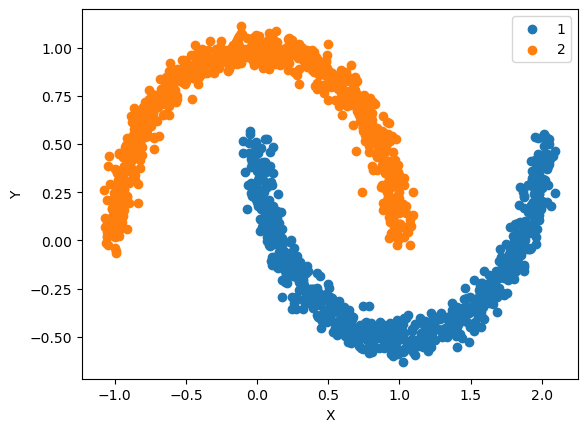

In [235]:
plt.figure(figsize=(10,7))

fig, ax = plt.subplots()

for cluster, df_cluster in merged_df.groupby('cluster'):
    ax.scatter(df_cluster['X'], df_cluster['Y'], label=cluster)

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()
    

### Executing for blobs dataset

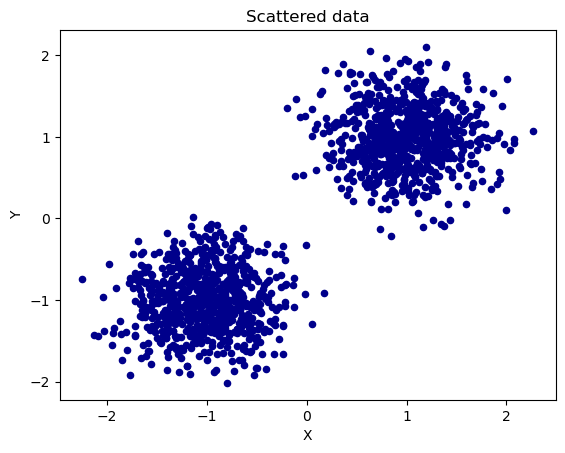

<Figure size 1000x700 with 0 Axes>

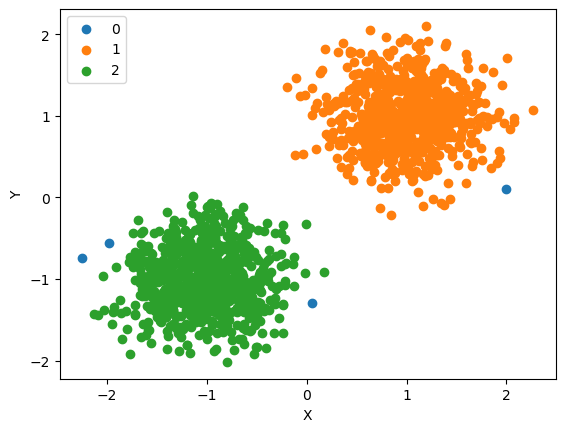

In [236]:
#epsilon = 7.5, MinPts = 3
df = pd.read_csv('blobs.csv')
df = df.rename(columns={'Xblobs_X1': 'X',
                        'Xblobs_X2': 'Y'})
df = df.reset_index(drop=False)
df.head()

epsilon = 0.25
minPts = 3


df.plot.scatter(x='X', y='Y', c='DarkBlue')
plt.title("Scattered data")

dbscan_dict = {}
vectors = df[["X", "Y"]].to_numpy()
dbscan_dict = get_neighbors(vectors, epsilon)

num_neighbor_list = num_neighbor(dbscan_dict)
cores,non_cores,outliers = defining_points(minPts,num_neighbor_list)

#data
clustered = cluster_with_stack(eps, minPts, df)

idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["index", "cluster"])

merged_df = pd.merge(df, cluster_df, on ='index')


plt.figure(figsize=(10,7))

fig, ax = plt.subplots()

for cluster, df_cluster in merged_df.groupby('cluster'):
    ax.scatter(df_cluster['X'], df_cluster['Y'], label=cluster)

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()
    

### Executing for circle dataset

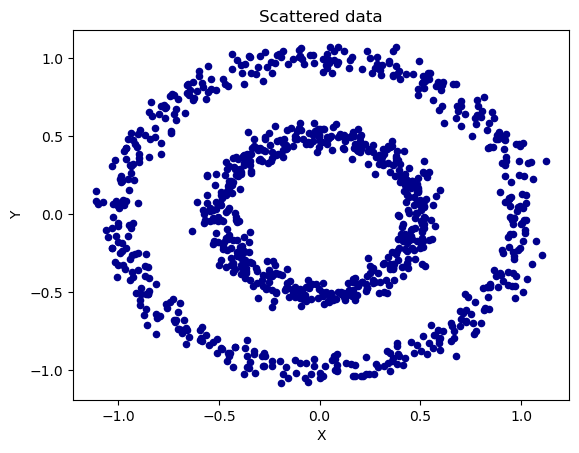

<Figure size 1000x700 with 0 Axes>

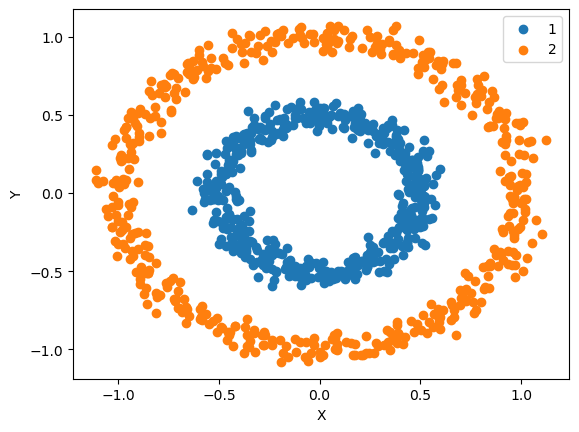

In [237]:
df = pd.read_csv('circle.csv')
df = df.rename(columns={'Xcircle_X1': 'X',
                        'Xcircle_X2': 'Y'})
df = df.reset_index(drop=False)
df.head()

epsilon = 0.1
minPts = 3

df.plot.scatter(x='X', y='Y', c='DarkBlue')
plt.title("Scattered data")

dbscan_dict = {}
vectors = df[["X", "Y"]].to_numpy()
dbscan_dict = get_neighbors(vectors, epsilon)

num_neighbor_list = num_neighbor(dbscan_dict)
cores,non_cores,outliers = defining_points(minPts,num_neighbor_list)

#data
clustered = cluster_with_stack(eps, minPts, df)

idx , cluster = list(zip(*clustered))
cluster_df = pd.DataFrame(clustered, columns = ["index", "cluster"])

merged_df = pd.merge(df, cluster_df, on ='index')

plt.figure(figsize=(10,7))

fig, ax = plt.subplots()

for cluster, df_cluster in merged_df.groupby('cluster'):
    ax.scatter(df_cluster['X'], df_cluster['Y'], label=cluster)

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()
    